# Cosmologically Correct Horizon Distances

Other resources:

 * [Chen and Holz (2016, unpub.)](https://dcc.ligo.org/LIGO-P1600071) Unfortunately, this requires authentication
 * [Belczynski et al., (2016)](http://www.nature.com/nature/journal/v534/n7608/fig_tab/nature18322_SF7.html) Examines the redshift distribution of potential LIGO targets in the BBH range, shows a comparative redshift horizon figure

In [1]:
%%bash
lalapps_version

LAL: 6.18.0.1 (CLEAN 9492705821595afe7eb850436b9b404e1f77a129)
LALFrame: 1.4.3.1 (CLEAN 9492705821595afe7eb850436b9b404e1f77a129)
LALMetaIO: 1.3.1.1 (CLEAN 9492705821595afe7eb850436b9b404e1f77a129)
LALXML: 1.2.4.1 (CLEAN 9492705821595afe7eb850436b9b404e1f77a129)
LALSimulation: 1.7.2.1 (CLEAN 9492705821595afe7eb850436b9b404e1f77a129)
LALBurst: 1.4.4.1 (CLEAN 9492705821595afe7eb850436b9b404e1f77a129)
LALInspiral: 1.7.7.1 (CLEAN 9492705821595afe7eb850436b9b404e1f77a129)
LALPulsar: 1.16.0.1 (CLEAN 9492705821595afe7eb850436b9b404e1f77a129)
LALInference: 1.9.1.1 (CLEAN 9492705821595afe7eb850436b9b404e1f77a129)
LALStochastic: 1.1.20.1 (CLEAN 9492705821595afe7eb850436b9b404e1f77a129)
LALApps: 6.21.0.1 (CLEAN 9492705821595afe7eb850436b9b404e1f77a129)


## Astropy cosmology

Documentation at: http://docs.astropy.org/en/v0.2.1/cosmology/index.html

In [2]:
%matplotlib inline
from matplotlib import pyplot
import numpy

import astropy
print astropy.__version__
from astropy import cosmology

import lal, lalsimulation
from lalinference.rapid_pe import lalsimutils
from pylal.antenna import response

1.3


[]

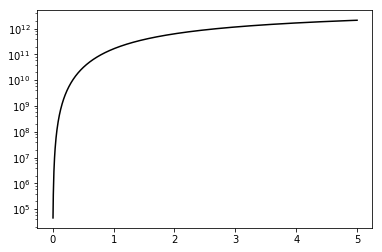

In [443]:
z_vals = numpy.linspace(0, 5, 1000)
v_com = cosmology.Planck15.comoving_volume(z_vals).value

pyplot.plot(z_vals, v_com, 'k-')
pyplot.semilogy()

## Power Spectral Densities

In [199]:
%%bash
rm *-GDS-CALIB_STRAIN.txt
wget https://losc.ligo.org/s/events/GW150914/P1500238/H1-GDS-CALIB_STRAIN.txt
wget https://losc.ligo.org/s/events/GW150914/P1500238/L1-GDS-CALIB_STRAIN.txt
wget https://dcc.ligo.org/public/0121/G1501223/003/2015-10-01_H1_O1_Sensitivity_displacement_asd.txt

--2017-04-05 14:26:10--  https://losc.ligo.org/s/events/GW150914/P1500238/H1-GDS-CALIB_STRAIN.txt
Resolving losc.ligo.org... 131.215.125.132
Connecting to losc.ligo.org|131.215.125.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3276850 (3.1M) [text/plain]
Saving to: ‘H1-GDS-CALIB_STRAIN.txt’

     0K .......... .......... .......... .......... ..........  1%  297K 11s
    50K .......... .......... .......... .......... ..........  3%  600K 8s
   100K .......... .......... .......... .......... ..........  4% 14.6M 5s
   150K .......... .......... .......... .......... ..........  6%  689K 5s
   200K .......... .......... .......... .......... ..........  7% 5.19M 4s
   250K .......... .......... .......... .......... ..........  9% 12.9M 3s
   300K .......... .......... .......... .......... .......... 10%  715K 3s
   350K .......... .......... .......... .......... .......... 12% 18.1M 3s
   400K .......... .......... .......... .......... .......... 14%

0.125


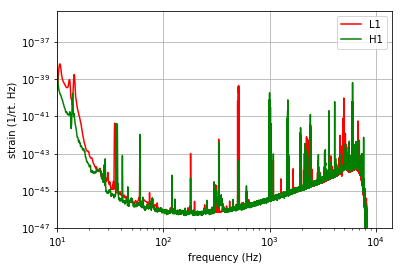

In [201]:
# Load PSDs
_, psd_l1 = numpy.loadtxt("L1-GDS-CALIB_STRAIN.txt", unpack=True)
#freq, psd_h1 = numpy.loadtxt("H1-GDS-CALIB_STRAIN.txt", unpack=True)
freq, psd_h1 = numpy.loadtxt("2015-10-01_H1_O1_Sensitivity_displacement_asd.txt", unpack=True)
df = freq[1]-freq[0]
print df

psd_l1 *= psd_l1
psd_h1 /= 4e3
psd_h1 *= psd_h1

pyplot.plot(freq, psd_l1, "r-", label="L1")
pyplot.plot(freq, psd_h1, "g-", label="H1")
pyplot.loglog()
pyplot.xlabel("frequency (Hz)")
pyplot.ylabel("strain (1/rt. Hz)")
pyplot.xlim(10, None)
pyplot.ylim(1e-47, None)
pyplot.grid()
pyplot.legend()

## 2018 Fully Advanced LIGO PSD

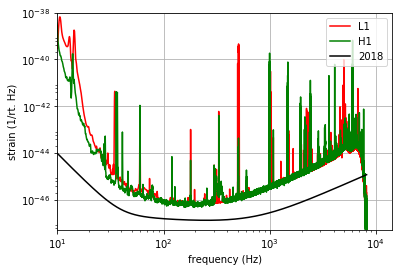

In [202]:
psd_2018 = map(lalsimulation.SimNoisePSDaLIGOZeroDetHighPower, freq)

pyplot.plot(freq, psd_l1, "r-", label="L1")
pyplot.plot(freq, psd_h1, "g-", label="H1")
pyplot.plot(freq, psd_2018, "k-", label="2018")
pyplot.loglog()
pyplot.xlabel("frequency (Hz)")
pyplot.ylabel("strain (1/rt. Hz)")
pyplot.xlim(10, None)
pyplot.ylim(.5e-47, 1e-38)
pyplot.grid()
pyplot.legend()

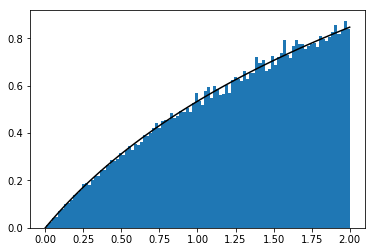

In [203]:
def logdistr(a, b, x):
    """
    http://mathworld.wolfram.com/LogarithmicDistribution.html
    """
    return numpy.log(x) / (b * (numpy.log(b) - 1) - a * (numpy.log(a) - 1))

def draw_logdistr(a, b, size=1):
    m = logdistr(a, b, b)
    ry = numpy.random.uniform(0, m, size)
    rx = numpy.random.uniform(a, b, size)
    while not numpy.all(ry < logdistr(a, b, rx)):
        rpass = ry < logdistr(a, b, rx)
        lpass = len(ry[~rpass])
        rx[~rpass] = numpy.random.uniform(a, b, lpass)
        ry[~rpass] = numpy.random.uniform(0, m, lpass)
    if size == 1:
        return rx[0]
    else:
        return rx

x = numpy.linspace(1, 3, 100)
pyplot.plot(x-1, logdistr(1, 3, x), 'k-')
pyplot.hist(draw_logdistr(1, 3, size=100000)-1, bins=100, normed=True);

In [450]:
def get_waveform(z, mc, **kwargs):
    m1, m2 = lalsimutils.m1m2(mc, 0.25)
    if "frame" in kwargs and kwargs["frame"] == "source":
        m1 *= (1+z)
        m2 *= (1+z)
    m1, m2 = m1 * lal.MSUN_SI, m2 * lal.MSUN_SI
    s1x, s1y, s1z = 0.0, 0.0, 0.0
    s2x, s2y, s2z = 0.0, 0.0, 0.0
    approx = lalsimulation.GetApproximantFromString(kwargs["approx"] if "approx" in kwargs else "IMRPhenomD")
    distance = kwargs["distance"] * lal.PC_SI * 1e6
    
    hp, hx = lalsimulation.SimInspiralFD(m1, m2,
                                     s1x, s1y, s1z,
                                     s2x, s2y, s2z,
                                     distance, numpy.pi/2 * 0, 0.0,
                                     0.0, 0.0, 0.0,
                                     df, 20, 2048, 30,
                                     None, approx)
    return hp, hx

def snr(hp, hx, psd, **kwargs):
    ht = hp.data.data + hx.data.data
    f0_idx, flast_idx = int(numpy.round(hp.f0 / hp.deltaF)), len(ht)
    flast_idx += f0_idx

    """
    # Debug plot
    hfreq = numpy.arange(hp.f0, 2048 + hp.deltaF, hp.deltaF)
    pyplot.figure()
    pyplot.plot(hfreq, numpy.abs(hp.data.data))
    pyplot.plot(freq, numpy.sqrt(psd), alpha=0.3, c='r')
    pyplot.plot(freq[f0_idx:flast_idx], numpy.sqrt(psd[f0_idx:flast_idx]), c='r')
    pyplot.loglog()
    """
    return 2 * numpy.sqrt(numpy.real(ht * ht.conj() / psd[f0_idx:flast_idx]).sum() * df)

#hp, hx = get_waveform(0, 28.0)
#print snr(hp, hx, psd_l1)
#print snr(hp, hx, psd_h1)

In [456]:
mc_min, mc_max = 3, 100
zmax = 2.0
def sample(n, fix_mc=None, vary_params=False, frame="source"):
    values = numpy.zeros((n, 3))
    values[:,0] = numpy.random.uniform(mc_min, mc_max, size=n) if fix_mc is None else fix_mc
    #values[:,1] = draw_logdistr(1, zmax + 1, size=n) - 1
    values[:,1] = numpy.random.uniform(0, zmax, size=n)
    distance = cosmology.Planck15.luminosity_distance(values[:,1]).value

    for i, (mc, z) in enumerate(values[:,:2]):

        hp, hx = get_waveform(z, mc, distance=distance[i], frame=frame)
        if vary_params:
            ra, dec = numpy.random.uniform(0, 2*numpy.pi), numpy.random.uniform(-numpy.pi/2, numpy.pi/2)
            incl, psi = numpy.arccos(numpy.random.uniform(-1, 1)), numpy.random.uniform(0, numpy.pi),
            fp, fx, _, _ = response(1e9, ra, dec, incl, psi, 'radians', 'L1')
            gp, gx = (1 + numpy.cos(incl)**2)/2, numpy.cos(incl)
        else: # optimal
            fp, fx = 1., 0.
            gp, gx = 1., 1.

        hp.data.data *= fp * gp
        hx.data.data *= fx * gx

        #h_snr = snr(hp, hx, psd_h1)
        h_snr = snr(hp, hx, psd_2018)
        
        """
        hp.data.data += hx.data.data
        psd_tmp = lal.CreateREAL8FrequencySeries("", 0, 0, df, lal.StrainUnit**2 / lal.HertzUnit, len(psd_h1))
        psd_tmp.data.data = psd_h1
        print lalsimulation.MeasureSNRFD(hp, psd_tmp, 20, 2048)
        """

        #print z, distance[i], mc, h_snr
        values[i,2] = h_snr
        
    return values, distance

#mc_gw150914, _ = lalsimutils.Mceta(35.7, 29.1)
#
# Horizon / volumes for "observer frame" GW150914
#
# Chen and Holz has the z_horizon at 0.349 for O1 -- we're about 10% off here.
#zsamp, dist = sample(10000, fix_mc=mc_gw150914, vary_params=False, frame="obs")

#
# Horizon / volumes for "source frame" GW150914
#
# Chen and Holz has the z_horizon at 0.42 for O1 --- we get this reasonably close
#zsamp, dist = sample(10000, fix_mc=mc_gw150914, vary_params=True, frame="source")

#
# Horizon / volumes for "observer frame" masses -- uniform distr. in chirp mass
#
#zsamp, dist = sample(100000, vary_params=True, frame="source")
zsamp, dist = sample(100000, vary_params=True, frame="source")

1.96484842113


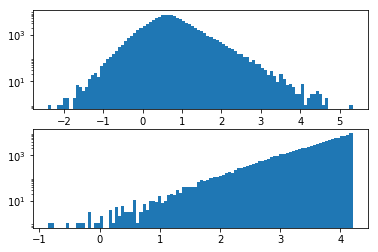

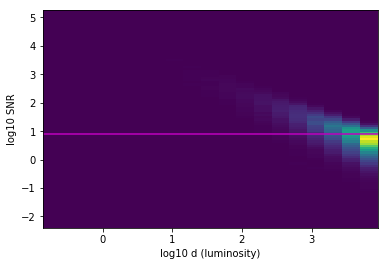

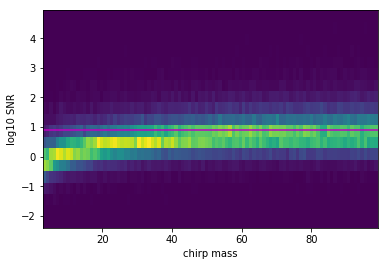

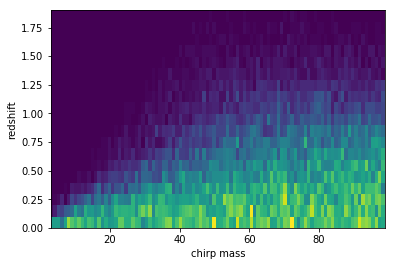

In [457]:
weights = numpy.where(zsamp[:,2] > 8, numpy.ones(zsamp.shape[0]), numpy.zeros(zsamp.shape[0]))
print zsamp[:,1][zsamp[:,2] > 8].max()

pyplot.figure()
pyplot.subplot(2, 1, 1)
pyplot.hist(numpy.log10(zsamp[:,2]), bins=100, log=True)
pyplot.subplot(2, 1, 2)
pyplot.hist(numpy.log10(dist), bins=100, log=True)

# SNR vs luminosity distance
pyplot.figure()
h, bx, by = numpy.histogram2d(numpy.log10(dist), numpy.log10(zsamp[:,2]), bins=(20, 100))
pyplot.pcolor(bx[:-1], by[:-1], h.T)
pyplot.axhline(numpy.log10(8), color='m')
pyplot.xlabel("log10 d (luminosity)")
pyplot.ylabel("log10 SNR")

# mchirp vs SNR
pyplot.figure()
h, bx, by = numpy.histogram2d(zsamp[:,0], numpy.log10(zsamp[:,2]), bins=(100, 20))
pyplot.pcolor(bx[:-1], by[:-1], h.T)
pyplot.axhline(numpy.log10(8), color='m')
pyplot.xlabel("chirp mass")
pyplot.ylabel("log10 SNR")

# mchirp vs z
pyplot.figure()
h, bx, by = numpy.histogram2d(zsamp[:,0], zsamp[:,1], range=((mc_min, mc_max), (0, zmax)), weights=weights, bins=(100, 20))
h_tot, bx, by = numpy.histogram2d(zsamp[:,0], zsamp[:,1], range=((mc_min, mc_max), (0, zmax)), bins=(100, 20))
# FIXME: This is a little dangerous, but we know we don't sample well at low z, but it's effectively one anyway
#h_tot[h_tot==0] = 1
#h[h_tot==0] = 1
pyplot.pcolor(bx[:-1], by[:-1], h.T)
pyplot.xlabel("chirp mass")
pyplot.ylabel("redshift")
pyplot.savefig("mchirp_z.png")

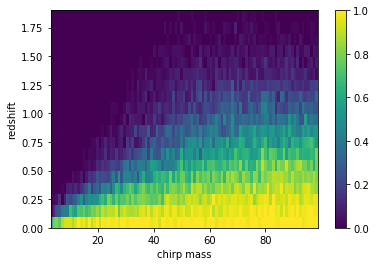

In [458]:
# mchirp vs z --- normalized
pyplot.figure()
pyplot.pcolor(bx[:-1], by[:-1], h.T/h_tot.T, vmin=0, vmax=1)
pyplot.xlabel("chirp mass")
pyplot.ylabel("redshift")
pyplot.colorbar()
pyplot.savefig("mchirp_z_norm.png")

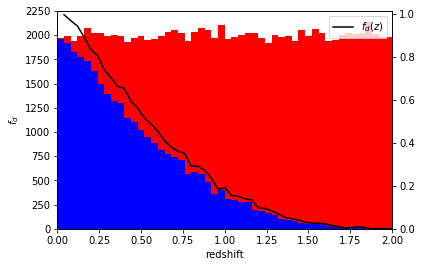

In [459]:
#zbins = numpy.logspace(-3, numpy.log10(2), 100, base=10)
denom, b, _ = pyplot.hist(zsamp[:,1], bins=50, range=(0, zmax), color='r', histtype='stepfilled')
h, _, _ = pyplot.hist(zsamp[zsamp[:,2]>8,1], bins=b, color='b', histtype='stepfilled')
pyplot.xlabel("redshift")
pyplot.ylabel(r"$f_d$")

z_vals = numpy.copy(b)[:-1] 
dz = b[1] - b[0]
z_vals += dz

f = h / denom.astype(float);
pyplot.twinx()
pyplot.plot(z_vals, f, 'k-', label=r"$f_d(z)$")
pyplot.ylim(0, 1.01)
pyplot.xlim(0, zmax)
pyplot.legend(loc="upper right")
pyplot.savefig("fofz_z.png")

See Belczynski, et al. (2014) eqn. 5:

$$
\overline{V_c} = \int \frac{dV}{dz} \frac{1}{1+z} f_d(z) dz
$$

In [455]:
dVdz = cosmology.Planck15.differential_comoving_volume(z_vals)
v_c = 4 * numpy.pi * astropy.units.sr * numpy.sum(dVdz / (1+z_vals) * f) * dz
d_c = (v_c * 3 / 4 / numpy.pi)**(1.0/3)

print v_c.to("Gpc^3")

print v_c / cosmology.Planck15.comoving_volume(z_vals[-1])

52.8742663325 Gpc3
0.0319280671676
